### Notebook 01 — Data Exploration & Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

df = pd.read_csv("../data/customer_support_tickets_dirty.csv")

In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUMAIDU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HUMAIDU\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Display options
pd.set_option("display.max_colwidth", 150)
pd.set_option("display.max_columns", None)

### Load the Dataset

In [5]:
## Load raw data
file_path = "../data/customer_support_tickets_dirty.csv"  
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()

Shape: (520, 4)


,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,Othr,1000,Dana
1,Can I migrate data from Freshdesk?,Othr,1001,Bob
2,Cannot update billing address; page keeps reloading.,billing,1002,Charlie
3,Looking for a product roadmap or upcoming features.,other,1003,Dana
4,Dark mode toggled but UI stays light.,Tech-support,1004,Alice


### Inspect Basic Information

In [6]:
# Basic structure
df.info()

# Missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Quick descriptive statistics
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        495 non-null    object
 1   label       495 non-null    object
 2   ticket_id   520 non-null    int64 
 3   agent_name  520 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.4+ KB

Missing values per column:
 text          25
label         25
ticket_id      0
agent_name     0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
text,495,180,Do you offer discounts for students or NGOs?,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,495,16,Accnt,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ticket_id,520.0,NaN,NaN,NaN,1259.5,150.255338,1000.0,1129.75,1259.5,1389.25,1519.0
agent_name,520,4,Alice,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean Column Names

In [7]:
# Clean and standardize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print("Renamed columns:", df.columns.tolist())

Renamed columns: ['text', 'label', 'ticket_id', 'agent_name']


### Quick Look at Unique Labels

In [8]:
# Check for label column - adapt name if needed
possible_label_cols = [c for c in df.columns if any(keyword in c.lower() for keyword in ['label', 'category', 'class', 'type'])]
print("Possible label columns:", possible_label_cols)

# Check for text column
possible_text_cols = [c for c in df.columns if any(keyword in c.lower() for keyword in ['text', 'ticket', 'message', 'content', 'description'])]
print("Possible text columns:", possible_text_cols)

# Auto-select or manual override
if possible_label_cols:
    label_col = possible_label_cols[0]  # Use first match
    print(f"Auto-selected label column: {label_col}")
else:
    label_col = "category"  # Fallback
    print(f"Using fallback label column: {label_col}")

if possible_text_cols:
    text_col = possible_text_cols[0]  # Use first match
    print(f"Auto-selected text column: {text_col}")
else:
    text_col = "ticket_text"  # Fallback
    print(f"Using fallback text column: {text_col}")

print(f"\nFinal selection:")
print(f"Label column: {label_col}")
print(f"Text column: {text_col}")

# Verify the columns exist and have data
if label_col in df.columns and text_col in df.columns:
    print(f"\nData verification:")
    print(f"Unique labels: {df[label_col].nunique()} - {df[label_col].unique()}")
    print(f"Text sample: {df[text_col].iloc[0][:100]}...")
else:
    print(f"ERROR: Columns '{label_col}' or '{text_col}' not found in DataFrame")
    print(f"Available columns: {list(df.columns)}")

Possible label columns: ['label']
Possible text columns: ['text', 'ticket_id']
Auto-selected label column: label
Auto-selected text column: text

Final selection:
Label column: label
Text column: text

Data verification:
Unique labels: 16 - ['Othr' 'billing' 'other' 'Tech-support' 'account' 'technical' 'Accnt'
 'OTHER' 'TECHNICAL' 'ACCOUNT' 'BILLING' 'Other ' nan 'Billng' 'Billing '
 ' Account ' ' Tech']
Text sample: Where can I find API rate limits documentation?...


In [9]:
print("Current columns:", df.columns.tolist())

Current columns: ['text', 'label', 'ticket_id', 'agent_name']


In [10]:
label_col = "label"  #can be change if needed
text_col = "text"  # can be change if needed

### Handle Missing and Duplicate Values

In [11]:
import pandas as pd
import re

# 1. First, let's see ALL unique label variations
print("BEFORE CLEANING - All label variations:")
print(df[label_col].value_counts())
print("\nUnique labels:", df[label_col].unique())
print(f"Total unique labels: {df[label_col].nunique()}")

BEFORE CLEANING - All label variations:
label
Accnt           42
 Tech           41
ACCOUNT         37
Othr            35
Billng          35
Billing         34
Other           33
technical       32
other           32
TECHNICAL       31
OTHER           28
billing         26
BILLING         25
 Account        22
account         21
Tech-support    21
Name: count, dtype: int64

Unique labels: ['Othr' 'billing' 'other' 'Tech-support' 'account' 'technical' 'Accnt'
 'OTHER' 'TECHNICAL' 'ACCOUNT' 'BILLING' 'Other ' nan 'Billng' 'Billing '
 ' Account ' ' Tech']
Total unique labels: 16


In [12]:
# 2. Clean the TEXT column (remove emojis, HTML tags, etc.)
def clean_text(text):
    if pd.isna(text):
        return text
    
    text = str(text)
    
    # Remove emojis and non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text.strip()

print("\nCLEANING TEXT COLUMN...")
df[text_col] = df[text_col].apply(clean_text)
print("Text cleaning completed")


CLEANING TEXT COLUMN...
Text cleaning completed


In [13]:
# Drop rows missing either text or label
df = df.dropna(subset=[text_col, label_col])

# Drop duplicates
df = df.drop_duplicates(subset=[text_col, label_col])

print("After cleaning:", df.shape)

After cleaning: (270, 4)


In [14]:
# 3. Standardize LABELS (fix case variations and abbreviations)
def standardize_label(label):
    if pd.isna(label):
        return 'other'  # Default for missing labels
    
    label = str(label).strip().lower()
    
    # Map variations to consistent names
    if label in ['tech', 'technical', 'tech_support', 'tech-support', 'tech support']:
        return 'tech_support'
    elif label in ['billing', 'bill', 'billng']:
        return 'billing'
    elif label in ['account', 'acct', 'accnt', 'accnt']:
        return 'account'
    elif label in ['other', 'othr', 'misc', 'miscellaneous']:
        return 'other'
    else:
        print(f"Unrecognized label: '{label}' - mapping to 'other'")
        return 'other'

print("\n STANDARDIZING LABELS...")
df[label_col] = df[label_col].apply(standardize_label)
print("Label standardization completed")


 STANDARDIZING LABELS...
Label standardization completed


In [15]:
# 4. Verify the cleaning
print("\n" + "="*50)
print("AFTER CLEANING - Final Results")
print("="*50)

print("\nFINAL LABEL DISTRIBUTION:")
print(df[label_col].value_counts())
print(f"\nUnique labels after cleaning: {df[label_col].unique()}")
print(f"Total categories: {df[label_col].nunique()}")


AFTER CLEANING - Final Results

FINAL LABEL DISTRIBUTION:
label
billing         78
tech_support    70
other           67
account         55
Name: count, dtype: int64

Unique labels after cleaning: ['other' 'billing' 'tech_support' 'account']
Total categories: 4


In [16]:
# 5. Show before/after samples (if we had original data)
print("\nCLEANING EXAMPLES:")
print("="*50)

# Show samples from different categories
for category in df[label_col].unique():
    category_samples = df[df[label_col] == category].head(2)
    print(f"\n{category.upper()} examples:")
    for idx, row in category_samples.iterrows():
        print(f"  Text: '{row[text_col][:80]}{'...' if len(row[text_col]) > 80 else ''}'")
    print(f"  Total {category} samples: {len(df[df[label_col] == category])}")


CLEANING EXAMPLES:

OTHER examples:
  Text: 'Where can I find API rate limits documentation?'
  Text: 'Can I migrate data from Freshdesk?'
  Total other samples: 67

BILLING examples:
  Text: 'Cannot update billing address; page keeps reloading.'
  Text: 'Promo code SPRING15 not applied at checkout.'
  Total billing samples: 78

TECH_SUPPORT examples:
  Text: 'Dark mode toggled but UI stays light.'
  Text: 'File export to CSV generates corrupted file.'
  Total tech_support samples: 70

ACCOUNT examples:
  Text: 'Incorrect role assigned; need admin access for my team.'
  Text: 'Username amina already taken but it's my old account.'
  Total account samples: 55


In [17]:
# 6. Generate comprehensive data quality report
print("\n" + "="*50)
print("DATA QUALITY REPORT")
print("="*50)

print(f"Total rows: {len(df):,}")
print(f"Total categories: {df[label_col].nunique()}")
print(f"Text column: '{text_col}'")
print(f"Label column: '{label_col}'")

print(f"\n LABEL DISTRIBUTION:")
label_counts = df[label_col].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {label:<15}: {count:>4} rows ({percentage:>5.1f}%)")

# Check for any remaining data issues
print(f"\n DATA QUALITY CHECKS:")
emoji_count = df[text_col].str.contains(r'[^\x00-\x7F]', na=False).sum()
html_count = df[text_col].str.contains(r'<[^>]+>', na=False).sum()
empty_text = df[text_col].isna().sum() | (df[text_col].str.strip() == '').sum()
empty_labels = df[label_col].isna().sum()

print(f"  Rows with emojis: {emoji_count}")
print(f"  Rows with HTML tags: {html_count}")
print(f"  Rows with empty text: {empty_text}")
print(f"  Rows with empty labels: {empty_labels}")

# Dataset balance assessment
print(f"\nDATASET BALANCE:")
max_count = label_counts.max()
min_count = label_counts.min()
balance_ratio = min_count / max_count if max_count > 0 else 0

print(f"  Most common label: {label_counts.idxmax()} ({max_count} rows)")
print(f"  Least common label: {label_counts.idxmin()} ({min_count} rows)")
print(f"  Balance ratio: {balance_ratio:.2f} (1.0 = perfectly balanced)")

if balance_ratio < 0.5:
    print("  Dataset is imbalanced - consider techniques like class weighting")
else:
    print(" Dataset is reasonably balanced")


DATA QUALITY REPORT
Total rows: 270
Total categories: 4
Text column: 'text'
Label column: 'label'

 LABEL DISTRIBUTION:
  billing        :   78 rows ( 28.9%)
  tech_support   :   70 rows ( 25.9%)
  other          :   67 rows ( 24.8%)
  account        :   55 rows ( 20.4%)

 DATA QUALITY CHECKS:
  Rows with emojis: 0
  Rows with HTML tags: 0
  Rows with empty text: 0
  Rows with empty labels: 0

DATASET BALANCE:
  Most common label: billing (78 rows)
  Least common label: account (55 rows)
  Balance ratio: 0.71 (1.0 = perfectly balanced)
 Dataset is reasonably balanced


In [18]:
# 7. Final summary
print("\n" + "="*50)
print("CLEANING COMPLETED SUCCESSFULLY")
print("="*50)

print(f"\n FINAL DATASET READY FOR TRAINING:")
print(f"   Rows: {len(df):,}")
print(f"   Categories: {df[label_col].nunique()}")
print(f"   Columns: {list(df.columns)}")

print(f"\n CATEGORY BREAKDOWN:")
for label in sorted(df[label_col].unique()):
    count = len(df[df[label_col] == label])
    print(f"   {label:<15}: {count:>4} samples")

print(f"\nNext step:data is now clean and ready for model training!")


CLEANING COMPLETED SUCCESSFULLY

 FINAL DATASET READY FOR TRAINING:
   Rows: 270
   Categories: 4
   Columns: ['text', 'label', 'ticket_id', 'agent_name']

 CATEGORY BREAKDOWN:
   account        :   55 samples
   billing        :   78 samples
   other          :   67 samples
   tech_support   :   70 samples

Next step:data is now clean and ready for model training!


### Explore Label Distribution

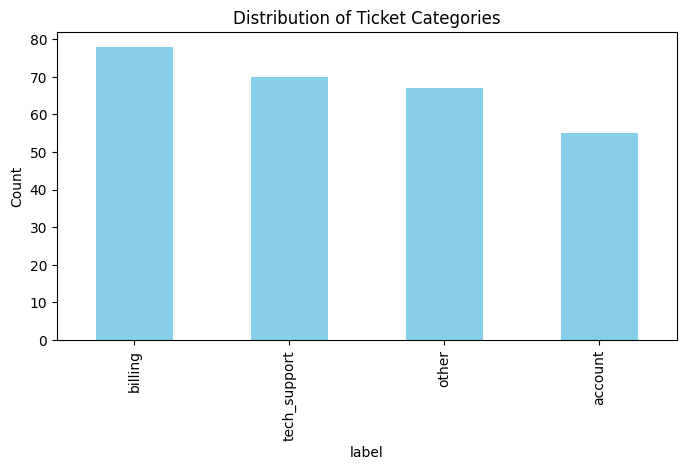

label
billing         0.288889
tech_support    0.259259
other           0.248148
account         0.203704
Name: proportion, dtype: float64

In [19]:
plt.figure(figsize=(8,4))
df[label_col].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Ticket Categories")
plt.ylabel("Count")
plt.show()

df[label_col].value_counts(normalize=True)

### Text Length Analysis

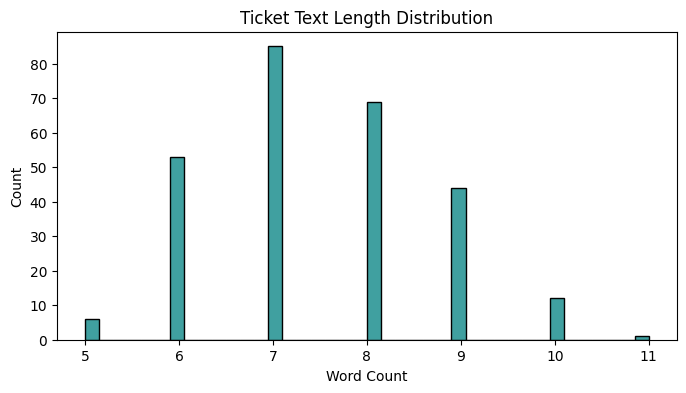

count    270.000000
mean       7.488889
std        1.190837
min        5.000000
25%        7.000000
50%        7.000000
75%        8.000000
max       11.000000
Name: text_length, dtype: float64

In [20]:
df["text_length"] = df[text_col].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,4))
sns.histplot(df["text_length"], bins=40, color='teal')
plt.title("Ticket Text Length Distribution")
plt.xlabel("Word Count")
plt.show()

df["text_length"].describe()

In [21]:
df.head()

,text,label,ticket_id,agent_name,text_length
0,Where can I find API rate limits documentation?,other,1000,Dana,8
1,Can I migrate data from Freshdesk?,other,1001,Bob,6
2,Cannot update billing address; page keeps reloading.,billing,1002,Charlie,7
3,Looking for a product roadmap or upcoming features.,other,1003,Dana,8
4,Dark mode toggled but UI stays light.,tech_support,1004,Alice,7


In [22]:
df.tail()

,text,label,ticket_id,agent_name,text_length
492,Overcharged by $49 on my last bill.,billing,1492,Charlie,7
493,Subscription renewal charged incorrectly this month. 12345,billing,1493,Bob,7
498,Charged twice for the same order #84341.,billing,1498,Dana,7
510,Requesting invoice to be sent monthly instead of weekly. 12345,other,1510,Bob,10
514,Refund not received after 7 days.,billing,1514,Alice,6


### Define Text Cleaning Function

In [23]:
STOP = set(stopwords.words('english'))
LEM = WordNetLemmatizer()

def clean_text(s):
    """Lowercase, remove URLs, punctuation, and stopwords"""
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+|www\S+|https\S+", "", s)  # remove URLs
    s = re.sub(r"[^a-z\s']", " ", s)               # keep only letters
    tokens = [t for t in s.split() if t and t not in STOP]
    lem = [LEM.lemmatize(t) for t in tokens]
    return " ".join(lem)

# Apply cleaning on a sample to verify
df[text_col].iloc[0], clean_text(df[text_col].iloc[0])


('Where can I find API rate limits documentation?',
 'find api rate limit documentation')

In [24]:
### apply cleaning to entire text column
df[text_col] = df[text_col].apply(clean_text)


In [25]:
output_path = "../data/customer_support_tickets_clean.csv"
df.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")


Cleaned dataset saved to: ../data/customer_support_tickets_clean.csv


### Summary

In [26]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("\nLabel Distribution:\n", df[label_col].value_counts())
print("\nExample rows:\n", df.sample(3))

Rows: 270
Columns: 5

Label Distribution:
 label
billing         78
tech_support    70
other           67
account         55
Name: count, dtype: int64

Example rows:
                                              text         label  ticket_id  \
112             promo code black applied checkout       billing       1112   
0               find api rate limit documentation         other       1000   
329  two factor prompt loop successful code entry  tech_support       1329   

    agent_name  text_length  
112        Bob            7  
0         Dana            8  
329        Bob            7  


Notebook Summary (Markdown)
Summary of Week 1:

Verified and cleaned dataset

Removed duplicates and missing rows

Cleaned and normalized text data

Saved cleaned version for modeling

Next step: Proceed to Week 2 — Baseline Models, where we’ll:

Implement Majority Classifier and TF-IDF + Logistic Regression

Generate baseline evaluation metrics

Save trained models and artifacts for later comparison